# EDA

In [142]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import snscrape.modules.twitter as sntwitter
from pathlib import Path  
import re
import string
from transformers import AutoTokenizer
#add package
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [143]:
# requirements 
# wordcloud
# scipy
# transformers
# tqdm
# matplotlib
# nltk


In [144]:
vaccine_df_2020_2021 = pd.read_csv(r'data/vaccine_output_2020_2021.csv')

#vaccine_df_2021_2022 = pd.read_csv(r'data/vaccine_output_2021_2022.csv')

In [145]:
vaccine_df_2020_2021.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5000 non-null   int64 
 1   Date        5000 non-null   object
 2   User        5000 non-null   object
 3   Tweet       5000 non-null   object
 4   Tweet_URL   5000 non-null   object
 5   Location    3787 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


In [146]:
print(vaccine_df_2020_2021.shape)

(5000, 6)


In [147]:
vaccine_df_2020_2021.head()

,Unnamed: 0,Date,User,Tweet,Tweet_URL,Location
0,0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,https://twitter.com/WebAeneas/status/146835672...,NaN
2,2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",https://twitter.com/TheAmirImani/status/146835...,Toronto
3,3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"


### PREPROCESSING TWEETS

In [148]:
# clean and filter using SPARK
def preprocessing(df):
    location_df = df['Location']
    tweet_lower_df = df['Tweet'].str.lower()
    EMOJI_PATTERN = re.compile( \
                           "[" \
                           "\U0001F1E0-\U0001F1FF"  \
                           "\U0001F300-\U0001F5FF"  \
                           "\U0001F600-\U0001F64F"  \
                           "\U0001F680-\U0001F6FF"  \
                           "\U0001F700-\U0001F77F" \
                           "\U0001F780-\U0001F7FF" \
                           "\U0001F800-\U0001F8FF" \
                           "\U0001F900-\U0001F9FF" \
                           "\U0001FA00-\U0001FA6F" \
                           "\U0001FA70-\U0001FAFF" \
                           "\U00002702-\U000027B0" \
                           "\U000024C2-\U0001F251" \
                           "]+")
    
    tweet_whitespace_df = tweet_lower_df.replace(r'\s+',' ',regex=True)
    tweet_emoji_df = tweet_whitespace_df.replace(EMOJI_PATTERN,'',regex = True)
    tweet_hashtag_df = tweet_emoji_df.replace(r'#','',regex=True)
    tweet_numbers_df = tweet_hashtag_df.replace(r'[0-9]+', '', regex = True)
    tweet_punc_df = tweet_numbers_df.replace(r'[^\w\s]', '', regex = True)
    
    location_whitespace_df =  location_df.replace(r'\s+',' ',regex=True)
    location_hashtag_df = location_whitespace_df.replace(r'#','',regex=True)
    location_numbers_df = location_hashtag_df.replace(r'[0-9]+','',regex=True)
    location_emoji_df = location_numbers_df.replace(EMOJI_PATTERN,'',regex = True)
    PUNCT_MODIFIED = r'[.|!|#|\"|$|%|\'|\(|\)|*|+|=|<|>|~|\{|\}|\\|/|:|;|\?|@|\[|^|_|\`|\]]'
    location_punc_df = location_emoji_df.replace(PUNCT_MODIFIED,'',regex = True)
    return tweet_punc_df,location_punc_df


In [149]:
vaccine_20_21_cleanedDF = vaccine_df_2020_2021
vaccine_20_21_cleanedDF['Processed_Tweet'],vaccine_20_21_cleanedDF['Location'] = preprocessing(vaccine_df_2020_2021)
vaccine_20_21_cleanedDF['Location'] = vaccine_20_21_cleanedDF['Location'].fillna('')
vaccine_20_21_cleanedDF

,Unnamed: 0,Date,User,Tweet,Tweet_URL,Location,Processed_Tweet
0,0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts",covidmythbustingtuesdays myth doesnt the covid...
1,1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,https://twitter.com/WebAeneas/status/146835672...,,vaccinated another great idea you can sue anyo...
2,2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",https://twitter.com/TheAmirImani/status/146835...,Toronto,i dont know if this is a dose vaccine or a se...
3,3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA",can anyone prove that the covid vaccine preven...
4,4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA",about people die each day from covid in the u...
...,...,...,...,...,...,...,...
4995,4995,2021-11-14 23:52:05+00:00,CarlaKent_1,I received my booster shot today at Eastern Hi...,https://twitter.com/CarlaKent_1/status/1460032...,"Louisville, KY",i received my booster shot today at eastern hi...
4996,4996,2021-11-14 23:46:46+00:00,AbanesCarla,Today is second dose day #Moderna #CovidVaccine,https://twitter.com/AbanesCarla/status/1460031...,Singapore,today is second dose day moderna covidvaccine
4997,4997,2021-11-14 23:36:41+00:00,Jersey_Sands,Well I'm not surprised they are predicting ano...,https://twitter.com/Jersey_Sands/status/146002...,,well im not surprised they are predicting anot...
4998,4998,2021-11-14 23:30:36+00:00,Trader_Danny,The only ones who have 100% immunity after the...,https://twitter.com/Trader_Danny/status/146002...,ManchesterLondon,the only ones who have immunity after the vac...


In [150]:
#Rearrange columns
col_list = vaccine_20_21_cleanedDF.columns.tolist()
cols = col_list[:-3] + col_list[-1:] + col_list[4:6]
vaccine_20_21_cleanedDF = vaccine_20_21_cleanedDF[cols]
vaccine_20_21_cleanedDF = vaccine_20_21_cleanedDF.rename({'Unnamed: 0': 'ID'}, axis=1) 
vaccine_20_21_cleanedDF.columns.tolist()


['ID', 'Date', 'User', 'Tweet', 'Processed_Tweet', 'Tweet_URL', 'Location']

In [151]:
vaccine_20_21_cleanedDF.to_csv(r'data/new_processed.csv', encoding='utf-8')

In [152]:
vaccine_20_21_cleanedDF.head()

,ID,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location
0,0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,covidmythbustingtuesdays myth doesnt the covid...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,
2,2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",i dont know if this is a dose vaccine or a se...,https://twitter.com/TheAmirImani/status/146835...,Toronto
3,3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,about people die each day from covid in the u...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"


(-0.5, 399.5, 199.5, -0.5)

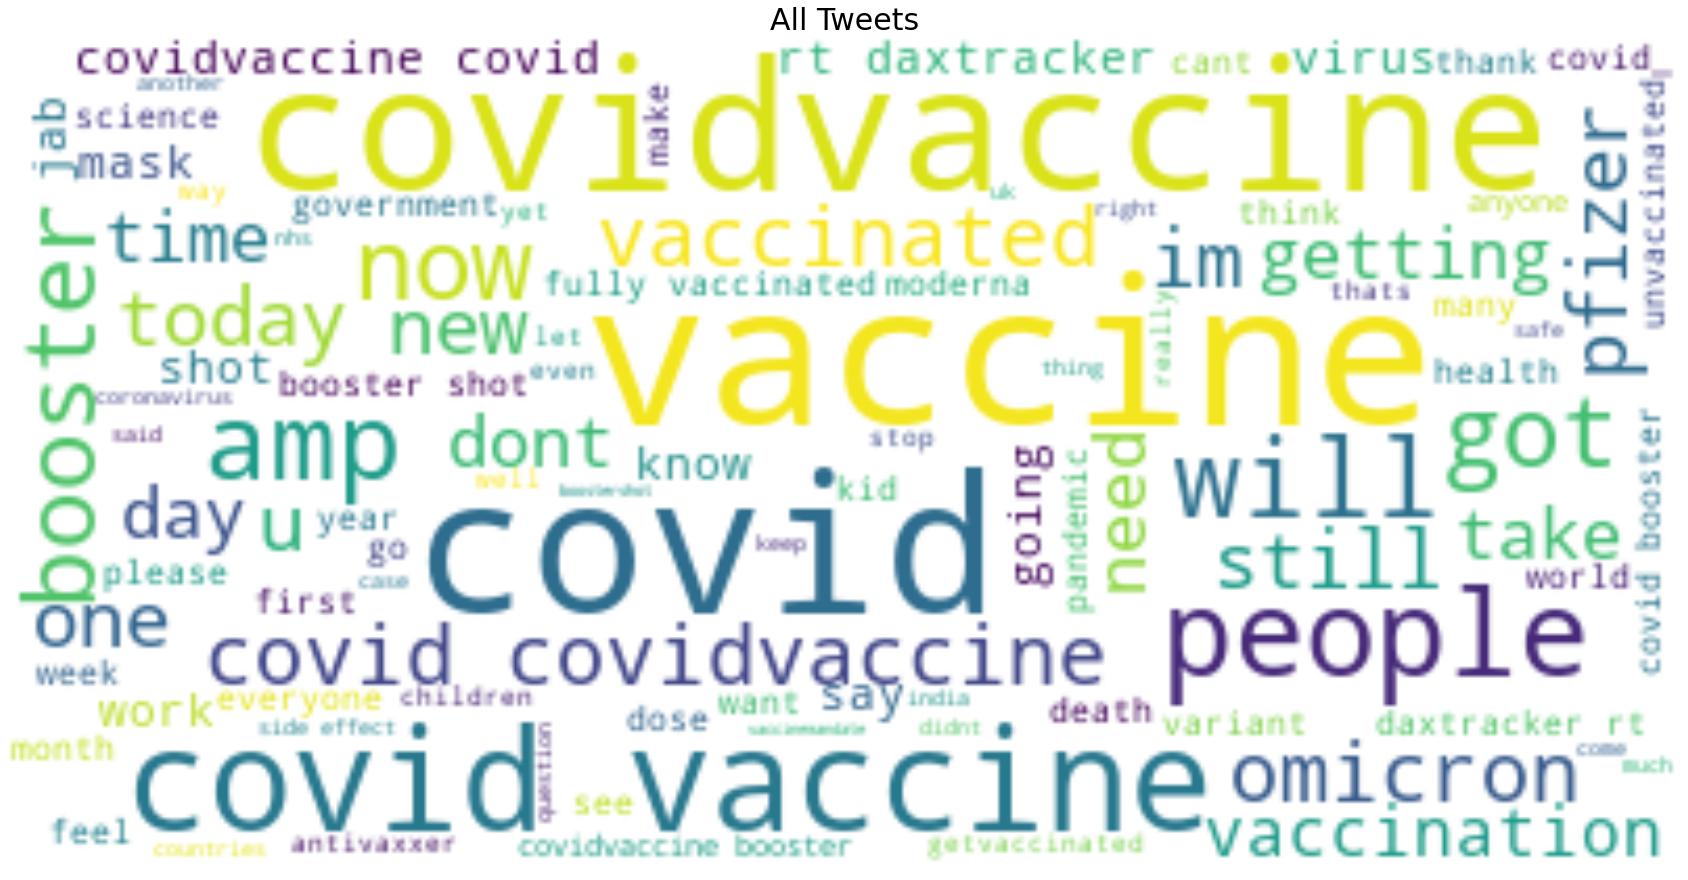

In [153]:

tweet_All = " ".join(review for review in vaccine_20_21_cleanedDF['Processed_Tweet'])

fig, ax = plt.subplots(1, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)


# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Tweets', fontsize=30)
ax.axis('off')


The Most Frequent words are 'CovidVaccine , Covid , Virus , Omicron ' Occurs almost in all the sentances , this along with the stop words wouldnt affect the performance of algorithms but words like Pfizer Moderna can help us determine the popular vaccine , and words such as "side effect  , death " can help us tag misinformed tweets about covid vaccine 

## ALGORITHMS

#### Basic NLTK Operations

In [154]:
sample = vaccine_20_21_cleanedDF['Processed_Tweet'][200]
print(sample)

#VADER 
#ROBERTA
#Compare and visualize 
#Pipeline for current tweet

got my covidvaccine booster please get yours too if youre able we all need to do our part to keep our communities safe getvaccinated grateful


In [155]:
tokens = nltk.word_tokenize(sample)
print(tokens)

['got', 'my', 'covidvaccine', 'booster', 'please', 'get', 'yours', 'too', 'if', 'youre', 'able', 'we', 'all', 'need', 'to', 'do', 'our', 'part', 'to', 'keep', 'our', 'communities', 'safe', 'getvaccinated', 'grateful']


In [156]:
tagged = nltk.pos_tag(tokens)
print(tagged)

[('got', 'VBD'), ('my', 'PRP$'), ('covidvaccine', 'NN'), ('booster', 'NN'), ('please', 'NN'), ('get', 'VB'), ('yours', 'RB'), ('too', 'RB'), ('if', 'IN'), ('youre', 'JJ'), ('able', 'JJ'), ('we', 'PRP'), ('all', 'DT'), ('need', 'VBP'), ('to', 'TO'), ('do', 'VB'), ('our', 'PRP$'), ('part', 'NN'), ('to', 'TO'), ('keep', 'VB'), ('our', 'PRP$'), ('communities', 'NNS'), ('safe', 'VBP'), ('getvaccinated', 'VBN'), ('grateful', 'JJ')]


In [157]:
#chunked into a sentance
Chunked_sentence_entities = nltk.chunk.ne_chunk(tagged)
Chunked_sentence_entities.pprint()

(S
  got/VBD
  my/PRP$
  covidvaccine/NN
  booster/NN
  please/NN
  get/VB
  yours/RB
  too/RB
  if/IN
  youre/JJ
  able/JJ
  we/PRP
  all/DT
  need/VBP
  to/TO
  do/VB
  our/PRP$
  part/NN
  to/TO
  keep/VB
  our/PRP$
  communities/NNS
  safe/VBP
  getvaccinated/VBN
  grateful/JJ)


### VADER SENTIMENT SCORING

In [204]:
nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/preethi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
Sentiment_analyzer = SentimentIntensityAnalyzer()
Vaders_result = {}
for idx,row in tqdm(vaccine_20_21_cleanedDF.iterrows(),total=len(vaccine_20_21_cleanedDF)):
    Processed_Tweet = row['Processed_Tweet']
    id = row['ID']
    Vaders_result[id] = Sentiment_analyzer.polarity_scores(Processed_Tweet)

In [159]:
Tweet_vaders = pd.DataFrame(result).T

In [160]:
Tweet_vaders

,neg,neu,pos,compound
0,0.114,0.772,0.115,0.0129
1,0.075,0.719,0.206,0.6581
2,0.103,0.802,0.095,-0.1027
3,0.000,0.966,0.034,0.0258
4,0.141,0.748,0.111,-0.3197
...,...,...,...,...
4995,0.000,0.847,0.153,0.4404
4996,0.000,1.000,0.000,0.0000
4997,0.100,0.779,0.121,-0.0170
4998,0.077,0.923,0.000,-0.1280


In [161]:
Tweet_vaders = Tweet_vaders.reset_index().rename(columns={'index' : 'ID'})
vaccine_20_21_cleanedDF

,ID,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location
0,0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,covidmythbustingtuesdays myth doesnt the covid...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,
2,2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",i dont know if this is a dose vaccine or a se...,https://twitter.com/TheAmirImani/status/146835...,Toronto
3,3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,about people die each day from covid in the u...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"
...,...,...,...,...,...,...,...
4995,4995,2021-11-14 23:52:05+00:00,CarlaKent_1,I received my booster shot today at Eastern Hi...,i received my booster shot today at eastern hi...,https://twitter.com/CarlaKent_1/status/1460032...,"Louisville, KY"
4996,4996,2021-11-14 23:46:46+00:00,AbanesCarla,Today is second dose day #Moderna #CovidVaccine,today is second dose day moderna covidvaccine,https://twitter.com/AbanesCarla/status/1460031...,Singapore
4997,4997,2021-11-14 23:36:41+00:00,Jersey_Sands,Well I'm not surprised they are predicting ano...,well im not surprised they are predicting anot...,https://twitter.com/Jersey_Sands/status/146002...,
4998,4998,2021-11-14 23:30:36+00:00,Trader_Danny,The only ones who have 100% immunity after the...,the only ones who have immunity after the vac...,https://twitter.com/Trader_Danny/status/146002...,ManchesterLondon


In [162]:
Tweet_vaders = Tweet_vaders.merge(vaccine_20_21_cleanedDF,how = 'left')
#we have sentiment score and meta data for each reviews
Tweet_vaders.head()


,ID,neg,neu,pos,compound,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location
0,0,0.114,0.772,0.115,0.0129,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,covidmythbustingtuesdays myth doesnt the covid...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,1,0.075,0.719,0.206,0.6581,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,
2,2,0.103,0.802,0.095,-0.1027,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",i dont know if this is a dose vaccine or a se...,https://twitter.com/TheAmirImani/status/146835...,Toronto
3,3,0.000,0.966,0.034,0.0258,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,4,0.141,0.748,0.111,-0.3197,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,about people die each day from covid in the u...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"


In [163]:
Tweet_vaders['Vader_Sentiment_Score'] =  Tweet_vaders[["neg", "neu","pos"]].max(axis=1)
Tweet_vaders_sentiment = Tweet_vaders
Tweet_vaders_sentiment['Vader_Sentiment'] = Tweet_vaders[["neg", "neu","pos"]].idxmax(axis=1)
Tweet_vaders_sentiment.head()

,ID,neg,neu,pos,compound,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location,Vader_Sentiment_Score,Vader_Sentiment
0,0,0.114,0.772,0.115,0.0129,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,covidmythbustingtuesdays myth doesnt the covid...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts",0.772,neu
1,1,0.075,0.719,0.206,0.6581,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,,0.719,neu
2,2,0.103,0.802,0.095,-0.1027,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",i dont know if this is a dose vaccine or a se...,https://twitter.com/TheAmirImani/status/146835...,Toronto,0.802,neu
3,3,0.000,0.966,0.034,0.0258,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA",0.966,neu
4,4,0.141,0.748,0.111,-0.3197,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,about people die each day from covid in the u...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA",0.748,neu


In [164]:
sentiment_counts = Tweet_vaders_sentiment.groupby(['Vader_Sentiment']).size()
print(sentiment_counts)

Vader_Sentiment
neg      12
neu    4953
pos      35
dtype: int64


<AxesSubplot:>

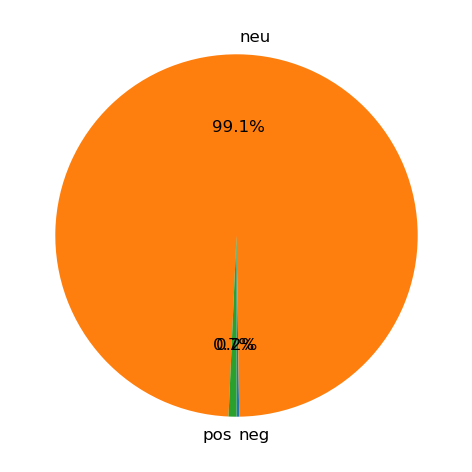

In [165]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

In [166]:
Tweet_vaders_sentiment.to_csv("data/vader_tweets.csv")

## ROBERTA TRANSFORMERS

In [172]:
#Hugging face - it will pull the model weights that are stored - transfer learning , we don't have to retrain the model at all
#it downloads all of the weights
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [173]:
#vader results
print(sample)
Sentiment_analyzer.polarity_scores(sample)

got my covidvaccine booster please get yours too if youre able we all need to do our part to keep our communities safe getvaccinated grateful


{'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'compound': 0.802}

In [175]:
#Run on Roberta Model
#encoding the text
#'pt' - pytorch
encoded_text = tokenizer(sample,return_tensors='pt')
encoded_text

{'input_ids': tensor([[    0, 22371,   127, 47268,   808, 39150,   833, 27028,  2540,   120,
         14314,   350,   114,    47,   241,   441,    52,    70,   240,     7,
           109,    84,   233,     7,   489,    84,  1822,  1522,   120, 39150,
          9339,  6161,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [176]:
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-2.5161,  0.6059,  1.5851]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [177]:
scores = output[0][0].detach().numpy()
scores


array([-2.5161407 ,  0.60593396,  1.585115  ], dtype=float32)

In [181]:
softmax_scores = softmax(scores)
softmax_scores

array([0.01188926, 0.2698079 , 0.71830285], dtype=float32)

In [183]:
scores_dict = {
    'roberta_neg' : softmax_scores[0],
    'roberta_neu' : softmax_scores[1],
    'roberta_pos' : softmax_scores[2]
}
print(scores_dict)

{'roberta_neg': 0.011889265, 'roberta_neu': 0.2698079, 'roberta_pos': 0.71830285}


In [184]:
def roberta_polarity_scores(sample):
    encoded = tokenizer(sample,return_tensors='pt')
    output = model(**encoded)
    scores=output[0][0].detach().numpy()
    softmax_scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores_softmax[0],
        'roberta_neu' : scores_softmax[1],
        'roberta_pos' : scores_softmax[2]
    }
    return scores_dict


In [191]:
#iterate over the dataset to calculate scores for each example
# some size of the text is too big for the roberta model to handle , we can skip those by adding try
result = {}
for i,row in tqdm(Tweet_vaders_sentiment.iterrows(),total=len(Tweet_vaders_sentiment)):
    try:
        tweet = row['Tweet']
        id = row['ID']
        vader_result = Sentiment_analyzer.polarity_scores(tweet)
        vader_result_rename = {}
        for key , value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = roberta_polarity_scores(tweet)
        #combining two dictionaries
        combined_result = {**vader_result,**roberta_result}
        #break
        result[id] = combined_result
    except RuntimeError:
        print(f'Text size too long for id: {id}')

  0%|          | 0/5000 [00:00<?, ?it/s]

In [198]:
Tweet_Roberta =  pd.DataFrame(result).T
Tweet_Roberta

,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,0.143,0.746,0.111,-0.3579,0.011889,0.269808,0.718303
1,0.075,0.719,0.206,0.6581,0.011889,0.269808,0.718303
2,0.097,0.813,0.089,-0.1027,0.011889,0.269808,0.718303
3,0.000,0.967,0.033,0.0258,0.011889,0.269808,0.718303
4,0.149,0.744,0.107,-0.4387,0.011889,0.269808,0.718303
...,...,...,...,...,...,...,...
4995,0.000,0.809,0.191,0.5826,0.011889,0.269808,0.718303
4996,0.000,1.000,0.000,0.0000,0.011889,0.269808,0.718303
4997,0.092,0.778,0.130,-0.2363,0.011889,0.269808,0.718303
4998,0.073,0.927,0.000,-0.1280,0.011889,0.269808,0.718303


In [199]:
Tweet_Roberta = Tweet_Roberta.reset_index().rename(columns={'index':'ID'})
Tweet_Roberta

,ID,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,0,0.143,0.746,0.111,-0.3579,0.011889,0.269808,0.718303
1,1,0.075,0.719,0.206,0.6581,0.011889,0.269808,0.718303
2,2,0.097,0.813,0.089,-0.1027,0.011889,0.269808,0.718303
3,3,0.000,0.967,0.033,0.0258,0.011889,0.269808,0.718303
4,4,0.149,0.744,0.107,-0.4387,0.011889,0.269808,0.718303
...,...,...,...,...,...,...,...,...
4995,4995,0.000,0.809,0.191,0.5826,0.011889,0.269808,0.718303
4996,4996,0.000,1.000,0.000,0.0000,0.011889,0.269808,0.718303
4997,4997,0.092,0.778,0.130,-0.2363,0.011889,0.269808,0.718303
4998,4998,0.073,0.927,0.000,-0.1280,0.011889,0.269808,0.718303


In [203]:
Tweet_Roberta = Tweet_vaders_sentiment.merge(Tweet_Roberta,how = 'left')

In [201]:
Tweet_Roberta

,ID,neg,neu,pos,compound,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location,Vader_Sentiment_Score,Vader_Sentiment,roberta_neg,roberta_neu,roberta_pos
0,0,0.114,0.772,0.115,0.0129,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,covidmythbustingtuesdays myth doesnt the covid...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts",0.772,neu,NaN,NaN,NaN
1,1,0.075,0.719,0.206,0.6581,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,,0.719,neu,0.011889,0.269808,0.718303
2,2,0.103,0.802,0.095,-0.1027,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",i dont know if this is a dose vaccine or a se...,https://twitter.com/TheAmirImani/status/146835...,Toronto,0.802,neu,NaN,NaN,NaN
3,3,0.000,0.966,0.034,0.0258,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA",0.966,neu,NaN,NaN,NaN
4,4,0.141,0.748,0.111,-0.3197,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,about people die each day from covid in the u...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA",0.748,neu,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,0.000,0.847,0.153,0.4404,2021-11-14 23:52:05+00:00,CarlaKent_1,I received my booster shot today at Eastern Hi...,i received my booster shot today at eastern hi...,https://twitter.com/CarlaKent_1/status/1460032...,"Louisville, KY",0.847,neu,NaN,NaN,NaN
4996,4996,0.000,1.000,0.000,0.0000,2021-11-14 23:46:46+00:00,AbanesCarla,Today is second dose day #Moderna #CovidVaccine,today is second dose day moderna covidvaccine,https://twitter.com/AbanesCarla/status/1460031...,Singapore,1.000,neu,0.011889,0.269808,0.718303
4997,4997,0.100,0.779,0.121,-0.0170,2021-11-14 23:36:41+00:00,Jersey_Sands,Well I'm not surprised they are predicting ano...,well im not surprised they are predicting anot...,https://twitter.com/Jersey_Sands/status/146002...,,0.779,neu,NaN,NaN,NaN
4998,4998,0.077,0.923,0.000,-0.1280,2021-11-14 23:30:36+00:00,Trader_Danny,The only ones who have 100% immunity after the...,the only ones who have immunity after the vac...,https://twitter.com/Trader_Danny/status/146002...,ManchesterLondon,0.923,neu,NaN,NaN,NaN
